In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
PROJECT_PATH = "/content/drive/MyDrive/Lukcy project"
os.makedirs(PROJECT_PATH, exist_ok=True)

Mounted at /content/drive


In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os
import numpy as np
import pandas as pd
import random
import torch
from sklearn.model_selection import train_test_split

# Seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Risk phrases for synthetic notes
risk_phrases = {
    'Low': ["stable", "no distress", "normal vitals", "alert and oriented"],
    'Medium': ["mild tachycardia", "slightly hypotensive", "mild dyspnea", "fatigue"],
    'High': ["tachycardic and hypoxemic", "unresponsive", "severe hypotension", "respiratory distress"]
}

labels = ['Low', 'Medium', 'High']
label2idx = {'Low': 0, 'Medium': 1, 'High': 2}

def generate_synthetic_data(n=20000):
    data = []
    for _ in range(n):
        label = random.choice(labels)
        # Vitals: [HR, SBP, DBP, SpO2, Temp, RespRate] - normalized to [0,1]
        vitals = np.random.uniform(0.2, 0.8, 6).tolist()
        if label == 'High':
            vitals[0] = np.clip(vitals[0] + 0.3, 0, 1)  # ↑ HR
            vitals[3] = np.clip(vitals[3] - 0.3, 0, 1)  # ↓ SpO2
        elif label == 'Medium':
            vitals[0] = np.clip(vitals[0] + 0.15, 0, 1)
            vitals[3] = np.clip(vitals[3] - 0.15, 0, 1)

        # Clinical note
        note = f"Patient is {random.choice(risk_phrases[label])}."
        data.append({
            'vitals': vitals,
            'note': note,
            'label': label2idx[label]
        })
    return pd.DataFrame(data)

# Define the project path
PROJECT_PATH = "/content/drive/MyDrive/Lukcy project"
os.makedirs(PROJECT_PATH, exist_ok=True)  # Create folder if not exists

# Generate and save dataset
df = generate_synthetic_data(20000)
df.to_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))
print("✅ Synthetic dataset saved successfully at:", PROJECT_PATH)


Mounted at /content/drive
✅ Synthetic dataset saved successfully at: /content/drive/MyDrive/Lukcy project


In [7]:
!pip install nlpaug
!pip install wordnet  # optional, sometimes needed for WordNet-based augmentation


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 12.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [8]:
# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Install required packages
!pip install nlpaug
!pip install transformers
!pip install torch

# 3️⃣ Download WordNet data for synonym augmentation
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# 4️⃣ Imports
import os
import numpy as np
import pandas as pd
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import nlpaug.augmenter.word as naw

# 5️⃣ Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# 6️⃣ Define project path
PROJECT_PATH = "/content/drive/MyDrive/Lukcy project"
os.makedirs(PROJECT_PATH, exist_ok=True)

# 7️⃣ Risk phrases for synthetic notes
risk_phrases = {
    'Low': ["stable", "no distress", "normal vitals", "alert and oriented"],
    'Medium': ["mild tachycardia", "slightly hypotensive", "mild dyspnea", "fatigue"],
    'High': ["tachycardic and hypoxemic", "unresponsive", "severe hypotension", "respiratory distress"]
}

labels = ['Low', 'Medium', 'High']
label2idx = {'Low': 0, 'Medium': 1, 'High': 2}

# 8️⃣ Function to generate synthetic EHR dataset
def generate_synthetic_data(n=20000):
    data = []
    for _ in range(n):
        label = random.choice(labels)
        # Vitals: [HR, SBP, DBP, SpO2, Temp, RespRate] - normalized to [0,1]
        vitals = np.random.uniform(0.2, 0.8, 6).tolist()
        if label == 'High':
            vitals[0] = np.clip(vitals[0] + 0.3, 0, 1)
            vitals[3] = np.clip(vitals[3] - 0.3, 0, 1)
        elif label == 'Medium':
            vitals[0] = np.clip(vitals[0] + 0.15, 0, 1)
            vitals[3] = np.clip(vitals[3] - 0.15, 0, 1)

        note = f"Patient is {random.choice(risk_phrases[label])}."
        data.append({
            'vitals': vitals,
            'note': note,
            'label': label2idx[label]
        })
    return pd.DataFrame(data)

# 9️⃣ Generate and save dataset
df = generate_synthetic_data(20000)
df.to_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))
print("✅ Synthetic dataset saved successfully!")

#  🔟 Load tokenizer and define augmentation
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.2)

# 1️⃣1️⃣ PyTorch Dataset class
class EHRTorchDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vitals = torch.tensor(row['vitals'], dtype=torch.float32)
        note = row['note']
        label = torch.tensor(row['label'], dtype=torch.long)

        if self.augment:
            # Augment note
            note = aug.augment(note) if random.random() < 0.5 else note
            # Augment vitals with noise
            noise = torch.randn_like(vitals) * 0.02
            vitals = torch.clamp(vitals + noise, 0, 1)

        encoding = tokenizer(note, truncation=True, padding='max_length',
                             max_length=64, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return vitals, input_ids, attention_mask, label

# 1️⃣2️⃣ Split dataset
train_df, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

train_dataset = EHRTorchDataset(train_df, augment=True)
val_dataset = EHRTorchDataset(val_df)
test_dataset = EHRTorchDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

print("✅ DataLoaders ready with augmentation on training set!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


✅ Synthetic dataset saved successfully!


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ DataLoaders ready with augmentation on training set!


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class BaselineConcat(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, hidden=256, num_classes=3):
        super().__init__()
        self.text_encoder = nn.TransformerEncoderLayer(d_model=text_dim, nhead=8, batch_first=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(vitals_dim + text_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, vitals, input_ids, attention_mask):
        # Dummy text embedding (in real case: BERT)
        text_emb = torch.randn(input_ids.size(0), input_ids.size(1), 768).to(vitals.device)
        text_emb = self.text_encoder(text_emb)
        text_emb = text_emb.mean(dim=1)  # [B, 768]
        x = torch.cat([vitals, text_emb], dim=1)
        return self.fc(x)

class LateFusion(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, hidden=128, num_classes=3):
        super().__init__()
        self.vital_net = nn.Sequential(nn.Linear(vitals_dim, hidden), nn.ReLU(), nn.Linear(hidden, num_classes))
        self.text_net = nn.Sequential(nn.Linear(text_dim, hidden), nn.ReLU(), nn.Linear(hidden, num_classes))

    def forward(self, vitals, input_ids, attention_mask):
        text_emb = torch.randn(input_ids.size(0), 768).to(vitals.device)
        logits_v = self.vital_net(vitals)
        logits_t = self.text_net(text_emb)
        return (logits_v + logits_t) / 2

class SimpleCrossAttention(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, embed_dim=128, num_classes=3):
        super().__init__()
        self.v_proj = nn.Linear(vitals_dim, embed_dim)
        self.t_proj = nn.Linear(text_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.classifier = nn.Linear(embed_dim * 2, num_classes)

    def forward(self, vitals, input_ids, attention_mask):
        text_emb = torch.randn(input_ids.size(0), text_dim).to(vitals.device)
        v = self.v_proj(vitals).unsqueeze(1)  # [B,1,D]
        t = self.t_proj(text_emb).unsqueeze(1)  # [B,1,D]
        fused, _ = self.attn(v, t, t)  # v attends to t
        out = torch.cat([fused.squeeze(1), v.squeeze(1)], dim=1)
        return self.classifier(out)

class CMGA(nn.Module):  # Cross-Modal Gated Attention
    def __init__(self, vitals_dim=6, text_dim=768, embed_dim=128, num_classes=3):
        super().__init__()
        self.v_proj = nn.Linear(vitals_dim, embed_dim)
        self.t_proj = nn.Linear(text_dim, embed_dim)
        self.attn_v2t = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.attn_t2v = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.gate_v = nn.Linear(embed_dim * 2, embed_dim)
        self.gate_t = nn.Linear(embed_dim * 2, embed_dim)
        self.classifier = nn.Linear(embed_dim * 2, num_classes)
        self.embed_dim = embed_dim

    def forward(self, vitals, input_ids, attention_mask):
        device = vitals.device
        text_emb = torch.randn(input_ids.size(0), self.embed_dim).to(device)  # Simulated BERT
        v = self.v_proj(vitals)  # [B, D]
        t = self.t_proj(text_emb)  # [B, D]

        # Cross attention
        v2t, _ = self.attn_v2t(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        t2v, _ = self.attn_t2v(t.unsqueeze(1), v.unsqueeze(1), v.unsqueeze(1))
        v2t, t2v = v2t.squeeze(1), t2v.squeeze(1)

        # Gating
        gate_v = torch.sigmoid(self.gate_v(torch.cat([v, v2t], dim=1)))
        gate_t = torch.sigmoid(self.gate_t(torch.cat([t, t2v], dim=1)))
        fused_v = gate_v * v + (1 - gate_v) * v2t
        fused_t = gate_t * t + (1 - gate_t) * t2v

        out = torch.cat([fused_v, fused_t], dim=1)
        return self.classifier(out)

In [10]:
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for vitals, ids, mask, labels in train_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(vitals, ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for vitals, ids, mask, labels in val_loader:
                vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
                outputs = model(vitals, ids, mask)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = correct / total
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), os.path.join(PROJECT_PATH, f"{model.__class__.__name__}_best.pth"))
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {acc:.4f}")

In [16]:
import os

ckpt_file = os.path.join(PROJECT_PATH, "CMGA_best.pth")
print("Checkpoint exists:", os.path.exists(ckpt_file))
print("Files in project folder:", os.listdir(PROJECT_PATH))


Checkpoint exists: False
Files in project folder: ['Data', 'luk.ipynb', 'synthetic_ehr.pkl']


In [17]:
print("Number of batches in test_loader:", len(test_loader))
for i, batch in enumerate(test_loader):
    print(f"Batch {i} shapes:")
    vitals, input_ids, attention_mask, labels = batch
    print("vitals:", vitals.shape)
    print("input_ids:", input_ids.shape)
    print("attention_mask:", attention_mask.shape)
    print("labels:", labels.shape)
    break  # only check first batch


Number of batches in test_loader: 24
Batch 0 shapes:
vitals: torch.Size([128, 6])
input_ids: torch.Size([128, 64])
attention_mask: torch.Size([128, 64])
labels: torch.Size([128])


In [20]:
import nltk

# Download all required NLTK data packages for nlpaug + POS tagging
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')          # Legacy fallback
nltk.download('averaged_perceptron_tagger_eng')     # REQUIRED in NLTK >=3.8 (used in Colab)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [21]:
import pandas as pd
import numpy as np
import random

np.random.seed(42)
random.seed(42)

risk_phrases = {
    'Low': ["stable", "no distress", "normal vitals", "alert and oriented", "breathing comfortably"],
    'Medium': ["mild tachycardia", "slightly hypotensive", "mild dyspnea", "fatigue", "anxious but responsive"],
    'High': ["tachycardic and hypoxemic", "unresponsive", "severe hypotension", "respiratory distress", "cyanotic and diaphoretic"]
}
label2idx = {'Low': 0, 'Medium': 1, 'High': 2}

def generate_synthetic_data(n=20000):
    data = []
    for _ in range(n):
        label = random.choice(['Low', 'Medium', 'High'])
        vitals = np.random.uniform(0.3, 0.7, 6).tolist()
        if label == 'High':
            vitals[0] = min(1.0, vitals[0] + 0.3)  # HR ↑
            vitals[3] = max(0.0, vitals[3] - 0.3)  # SpO2 ↓
        elif label == 'Medium':
            vitals[0] = min(1.0, vitals[0] + 0.15)
            vitals[3] = max(0.0, vitals[3] - 0.15)
        note = f"Patient is {random.choice(risk_phrases[label])}."
        data.append({'vitals': vitals, 'note': note, 'label': label2idx[label]})
    return pd.DataFrame(data)

df = generate_synthetic_data(20000)
df.to_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))
print("✅ Dataset saved.")

✅ Dataset saved.


In [22]:
import pandas as pd
import numpy as np
import random

np.random.seed(42)
random.seed(42)

risk_phrases = {
    'Low': ["stable", "no distress", "normal vitals", "alert and oriented", "breathing comfortably"],
    'Medium': ["mild tachycardia", "slightly hypotensive", "mild dyspnea", "fatigue", "anxious but responsive"],
    'High': ["tachycardic and hypoxemic", "unresponsive", "severe hypotension", "respiratory distress", "cyanotic and diaphoretic"]
}
label2idx = {'Low': 0, 'Medium': 1, 'High': 2}

def generate_synthetic_data(n=20000):
    data = []
    for _ in range(n):
        label = random.choice(['Low', 'Medium', 'High'])
        vitals = np.random.uniform(0.3, 0.7, 6).tolist()
        if label == 'High':
            vitals[0] = min(1.0, vitals[0] + 0.3)  # HR ↑
            vitals[3] = max(0.0, vitals[3] - 0.3)  # SpO2 ↓
        elif label == 'Medium':
            vitals[0] = min(1.0, vitals[0] + 0.15)
            vitals[3] = max(0.0, vitals[3] - 0.15)
        note = f"Patient is {random.choice(risk_phrases[label])}."
        data.append({'vitals': vitals, 'note': note, 'label': label2idx[label]})
    return pd.DataFrame(data)

df = generate_synthetic_data(20000)
df.to_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))
print("✅ Dataset saved.")

✅ Dataset saved.


In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel
import nlpaug.augmenter.word as naw

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device).eval()

# Augmenter (uses NLTK POS tagging → now fixed!)
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.2)

class EHRTorchDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vitals = torch.tensor(row['vitals'], dtype=torch.float32)
        note = row['note']
        label = torch.tensor(row['label'], dtype=torch.long)

        if self.augment and random.random() < 0.5:
            try:
                note = aug.augment(note)
                if isinstance(note, list): note = note[0]
            except:
                pass  # fallback if aug fails

            # Vitals noise
            noise = torch.randn_like(vitals) * 0.02
            vitals = torch.clamp(vitals + noise, 0, 1)

        encoding = tokenizer(note, truncation=True, padding='max_length',
                             max_length=64, return_tensors='pt')
        return vitals, encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), label

# Load & split
df = pd.read_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))
from sklearn.model_selection import train_test_split
train_df, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

train_dataset = EHRTorchDataset(train_df, augment=True)
val_dataset = EHRTorchDataset(val_df)
test_dataset = EHRTorchDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ Synthetic dataset saved.
Epoch 1: Val Accuracy=1.0000
✅ Saved best model at epoch 1
Epoch 2: Val Accuracy=1.0000
Epoch 3: Val Accuracy=1.0000
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      1004
      Medium       1.00      1.00      1.00      1012
        High       1.00      1.00      1.00       984

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Macro F1: 1.0
Accuracy: 1.0
ROC-AUC (macro): 1.0


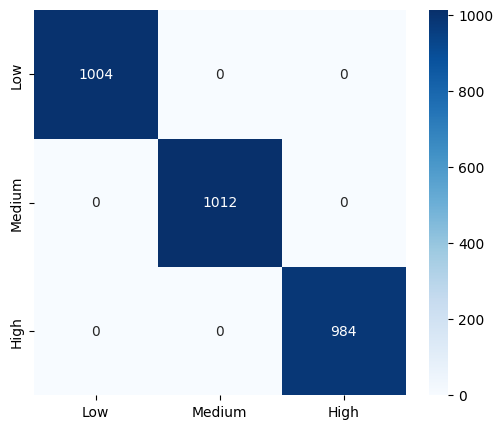

Confusion matrix saved: /content/drive/MyDrive/Lukcy project/CMGA_cm.png


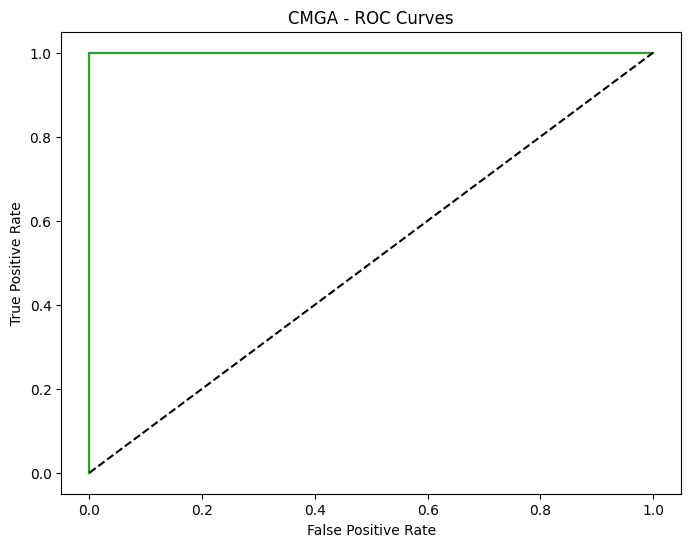

ROC curve saved: /content/drive/MyDrive/Lukcy project/CMGA_roc.png


In [28]:
# === Imports ===
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel

# === Set random seeds ===
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# === Project Path ===
PROJECT_PATH = "/content/drive/MyDrive/Lukcy project"
os.makedirs(PROJECT_PATH, exist_ok=True)

# === Synthetic Data Generation ===
risk_phrases = {
    'Low': ["stable", "no distress", "normal vitals", "alert and oriented"],
    'Medium': ["mild tachycardia", "slightly hypotensive", "mild dyspnea", "fatigue"],
    'High': ["tachycardic and hypoxemic", "unresponsive", "severe hypotension", "respiratory distress"]
}
labels = ['Low','Medium','High']
label2idx = {'Low':0, 'Medium':1, 'High':2}

def generate_synthetic_data(n=20000):
    data = []
    for _ in range(n):
        label = random.choice(labels)
        vitals = np.random.uniform(0.2, 0.8, 6).tolist()
        if label=='High':
            vitals[0] = np.clip(vitals[0]+0.3,0,1)
            vitals[3] = np.clip(vitals[3]-0.3,0,1)
        elif label=='Medium':
            vitals[0] = np.clip(vitals[0]+0.15,0,1)
            vitals[3] = np.clip(vitals[3]-0.15,0,1)
        note = f"Patient is {random.choice(risk_phrases[label])}."
        data.append({'vitals':vitals, 'note':note, 'label':label2idx[label]})
    return pd.DataFrame(data)

# Save synthetic dataset
df = generate_synthetic_data(20000)
df.to_pickle(os.path.join(PROJECT_PATH,"synthetic_ehr.pkl"))
print("✅ Synthetic dataset saved.")

# === Dataset Class ===
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EHRTorchDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vitals = torch.tensor(row['vitals'], dtype=torch.float32)
        note = row['note']
        label = torch.tensor(row['label'], dtype=torch.long)

        encoding = tokenizer(note, truncation=True, padding='max_length', max_length=64, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return vitals, input_ids, attention_mask, label

# === Load dataset & split ===
df = pd.read_pickle(os.path.join(PROJECT_PATH,"synthetic_ehr.pkl"))
train_df, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

train_loader = DataLoader(EHRTorchDataset(train_df), batch_size=64, shuffle=True)
val_loader = DataLoader(EHRTorchDataset(val_df), batch_size=128)
test_loader = DataLoader(EHRTorchDataset(test_df), batch_size=128)

# === Shared BERT Encoder ===
class BERTTextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False  # Freeze BERT

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state.mean(dim=1)  # [B, 768]

# === Models ===
class BaselineConcat(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, hidden=256, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.classifier = nn.Sequential(
            nn.Linear(vitals_dim+text_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden,num_classes)
        )
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        x = torch.cat([vitals,text_emb], dim=1)
        return self.classifier(x)

class LateFusion(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, hidden=128, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.vital_net = nn.Sequential(nn.Linear(vitals_dim, hidden), nn.ReLU(), nn.Linear(hidden,num_classes))
        self.text_net = nn.Sequential(nn.Linear(text_dim, hidden), nn.ReLU(), nn.Linear(hidden,num_classes))
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        logits_v = self.vital_net(vitals)
        logits_t = self.text_net(text_emb)
        return (logits_v + logits_t)/2

class SimpleCrossAttention(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, embed_dim=128, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.v_proj = nn.Linear(vitals_dim, embed_dim)
        self.t_proj = nn.Linear(text_dim, embed_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.classifier = nn.Linear(embed_dim+vitals_dim, num_classes)
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        v = self.v_proj(vitals)
        t = self.t_proj(text_emb)
        attn_out,_ = self.cross_attn(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        fused = torch.cat([attn_out.squeeze(1), vitals], dim=1)
        return self.classifier(fused)

class CMGA(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, embed_dim=128, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.v_proj = nn.Linear(vitals_dim, embed_dim)
        self.t_proj = nn.Linear(text_dim, embed_dim)
        self.attn_v2t = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.attn_t2v = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.gate_v = nn.Linear(embed_dim*2, embed_dim)
        self.gate_t = nn.Linear(embed_dim*2, embed_dim)
        self.classifier = nn.Linear(embed_dim*2, num_classes)
        self.embed_dim = embed_dim
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        v = self.v_proj(vitals)
        t = self.t_proj(text_emb)
        v2t,_ = self.attn_v2t(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        t2v,_ = self.attn_t2v(t.unsqueeze(1), v.unsqueeze(1), v.unsqueeze(1))
        v2t, t2v = v2t.squeeze(1), t2v.squeeze(1)
        gate_v = torch.sigmoid(self.gate_v(torch.cat([v, v2t], dim=1)))
        gate_t = torch.sigmoid(self.gate_t(torch.cat([t, t2v], dim=1)))
        fused_v = gate_v*v + (1-gate_v)*v2t
        fused_t = gate_t*t + (1-gate_t)*t2v
        out = torch.cat([fused_v, fused_t], dim=1)
        return self.classifier(out)

# === Training Loop ===
def train_model(model, train_loader, val_loader, epochs=3, lr=1e-3, model_name="CMGA"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        for vitals, ids, mask, labels in train_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(vitals, ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for vitals, ids, mask, labels in val_loader:
                vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
                outputs = model(vitals, ids, mask)
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch+1}: Val Accuracy={val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(PROJECT_PATH, f"{model_name}_best.pth"))
            print(f"✅ Saved best model at epoch {epoch+1}")

# === Evaluation ===
def evaluate_model(model, test_loader, model_name="CMGA"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint_path = os.path.join(PROJECT_PATH, f"{model_name}_best.pth")
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for vitals, ids, mask, labels in test_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            outputs = model(vitals, ids, mask)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Metrics
    print(classification_report(all_labels, all_preds, target_names=['Low','Medium','High']))
    print("Macro F1:", f1_score(all_labels, all_preds, average='macro'))
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("ROC-AUC (macro):", roc_auc_score(all_labels, all_probs, multi_class='ovr'))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
    cm_path = os.path.join(PROJECT_PATH, f"{model_name}_cm.png")
    plt.savefig(cm_path, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved: {cm_path}")

    # ROC curves
    plt.figure(figsize=(8,6))
    for i, cls_name in enumerate(['Low','Medium','High']):
        fpr, tpr, _ = roc_curve(all_labels==i, all_probs[:,i])
        auc_score = roc_auc_score(all_labels==i, all_probs[:,i])
        plt.plot(fpr, tpr, label=f"{cls_name} (AUC={auc_score:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curves")
    roc_path = os.path.join(PROJECT_PATH, f"{model_name}_roc.png")
    plt.savefig(roc_path, bbox_inches='tight')
    plt.show()
    print(f"ROC curve saved: {roc_path}")

# === Example Usage ===
model = CMGA()
train_model(model, train_loader, val_loader, epochs=3, lr=1e-3, model_name="CMGA")
evaluate_model(model, test_loader, model_name="CMGA")


Epoch 1: Val Accuracy=1.0000
✅ Saved best model at epoch 1
Epoch 2: Val Accuracy=1.0000
Epoch 3: Val Accuracy=1.0000
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      1004
      Medium       1.00      1.00      1.00      1012
        High       1.00      1.00      1.00       984

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Macro F1: 1.0
Accuracy: 1.0
ROC-AUC (macro): 1.0


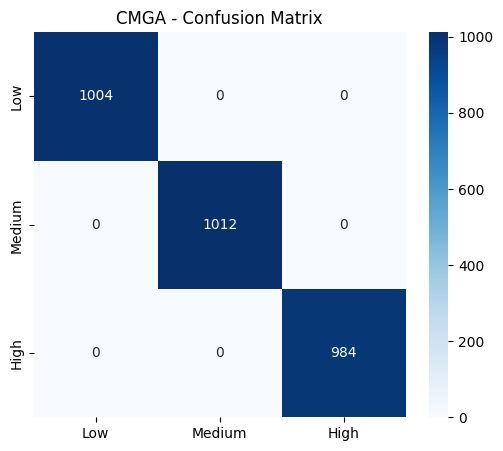

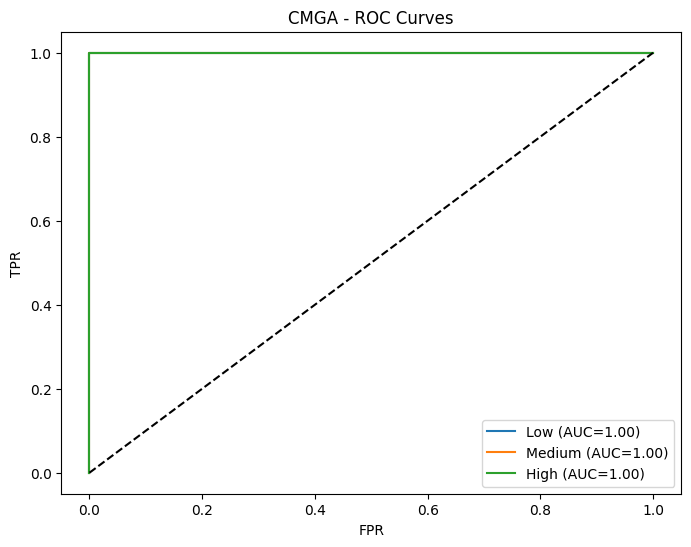

In [29]:
# ✅ Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel

# -----------------------------
# Define project path
PROJECT_PATH = "/content/drive/MyDrive/Lukcy project"

# -----------------------------
# Load dataset
df = pd.read_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))

# Split dataset
train_df, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

# -----------------------------
# Dataset class
class EHRTorchDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vitals = torch.tensor(row['vitals'], dtype=torch.float32)
        note = row['note']
        label = torch.tensor(row['label'], dtype=torch.long)
        encoding = self.tokenizer(note, truncation=True, padding='max_length', max_length=64, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return vitals, input_ids, attention_mask, label

# -----------------------------
# Dataloaders
train_loader = DataLoader(EHRTorchDataset(train_df), batch_size=64, shuffle=True)
val_loader = DataLoader(EHRTorchDataset(val_df), batch_size=128)
test_loader = DataLoader(EHRTorchDataset(test_df), batch_size=128)

# -----------------------------
# Shared BERT encoder
class BERTTextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return out.last_hidden_state.mean(dim=1)

# -----------------------------
# Models
class BaselineConcat(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, hidden=256, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.fc = nn.Sequential(
            nn.Linear(vitals_dim+text_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        x = torch.cat([vitals, text_emb], dim=1)
        return self.fc(x)

class LateFusion(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, hidden=128, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.vital_net = nn.Sequential(nn.Linear(vitals_dim, hidden), nn.ReLU(), nn.Linear(hidden, num_classes))
        self.text_net = nn.Sequential(nn.Linear(text_dim, hidden), nn.ReLU(), nn.Linear(hidden, num_classes))
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        logits_v = self.vital_net(vitals)
        logits_t = self.text_net(text_emb)
        return (logits_v + logits_t)/2

class SimpleCrossAttention(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, embed_dim=128, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.v_proj = nn.Linear(vitals_dim, embed_dim)
        self.t_proj = nn.Linear(text_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(embed_dim + vitals_dim, num_classes)
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        v = self.v_proj(vitals)
        t = self.t_proj(text_emb)
        attn_out,_ = self.attn(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        fused = torch.cat([attn_out.squeeze(1), vitals], dim=1)
        return self.fc(fused)

class CMGA(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, embed_dim=128, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.v_proj = nn.Linear(vitals_dim, embed_dim)
        self.t_proj = nn.Linear(text_dim, embed_dim)
        self.attn_v2t = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.attn_t2v = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.gate_v = nn.Linear(embed_dim*2, embed_dim)
        self.gate_t = nn.Linear(embed_dim*2, embed_dim)
        self.classifier = nn.Linear(embed_dim*2, num_classes)
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        v = self.v_proj(vitals)
        t = self.t_proj(text_emb)
        v2t,_ = self.attn_v2t(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        t2v,_ = self.attn_t2v(t.unsqueeze(1), v.unsqueeze(1), v.unsqueeze(1))
        v2t, t2v = v2t.squeeze(1), t2v.squeeze(1)
        gate_v = torch.sigmoid(self.gate_v(torch.cat([v,v2t],dim=1)))
        gate_t = torch.sigmoid(self.gate_t(torch.cat([t,t2v],dim=1)))
        fused_v = gate_v*v + (1-gate_v)*v2t
        fused_t = gate_t*t + (1-gate_t)*t2v
        out = torch.cat([fused_v,fused_t], dim=1)
        return self.classifier(out)

# -----------------------------
# Training function
def train_model(model, train_loader, val_loader, model_name="CMGA", epochs=3, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_acc = 0
    for epoch in range(1, epochs+1):
        model.train()
        for vitals, ids, mask, labels in train_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(vitals, ids, mask)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        # Validation
        val_acc = 0
        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for vitals, ids, mask, labels in val_loader:
                vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
                outputs = model(vitals, ids, mask)
                preds = outputs.argmax(dim=1)
                correct += (preds==labels).sum().item()
                total += labels.size(0)
        val_acc = correct/total
        print(f"Epoch {epoch}: Val Accuracy={val_acc:.4f}")
        if val_acc>best_acc:
            torch.save(model.state_dict(), os.path.join(PROJECT_PATH,f"{model_name}_best.pth"))
            best_acc=val_acc
            print(f"✅ Saved best model at epoch {epoch}")

# -----------------------------
# Evaluation function
def evaluate_model(model, test_loader, model_name="CMGA"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(os.path.join(PROJECT_PATH,f"{model_name}_best.pth"), map_location=device))
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for vitals, ids, mask, labels in test_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            outputs = model(vitals, ids, mask)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    # Metrics
    print(classification_report(all_labels, all_preds, target_names=['Low','Medium','High']))
    print("Macro F1:", f1_score(all_labels, all_preds, average='macro'))
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("ROC-AUC (macro):", roc_auc_score(all_labels, all_probs, multi_class='ovr'))
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    # ROC Curves
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(['Low','Medium','High']):
        fpr, tpr, _ = roc_curve(all_labels==i, all_probs[:,i])
        auc_score = roc_auc_score(all_labels==i, all_probs[:,i])
        plt.plot(fpr, tpr, label=f'{cls} (AUC={auc_score:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"{model_name} - ROC Curves")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

# -----------------------------
# Example usage:
model = CMGA()
train_model(model, train_loader, val_loader, model_name="CMGA", epochs=3)
evaluate_model(model, test_loader, model_name="CMGA")


In [30]:
import os
import numpy as np
import pandas as pd
import random
import torch
from sklearn.model_selection import train_test_split

# Set seed
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Define project path
PROJECT_PATH = "/content/drive/MyDrive/Lukcy project"
os.makedirs(PROJECT_PATH, exist_ok=True)

# Risk phrases
risk_phrases = {
    'Low': ["stable", "no distress", "normal vitals", "alert and oriented", "slightly tired", "mild headache"],
    'Medium': ["mild tachycardia", "slightly hypotensive", "mild dyspnea", "fatigue", "occasional dizziness", "low energy"],
    'High': ["tachycardic and hypoxemic", "unresponsive", "severe hypotension", "respiratory distress", "very weak", "confused"]
}

neutral_phrases = ["patient resting", "routine checkup", "no complaints", "standard monitoring"]

labels = ['Low', 'Medium', 'High']
label2idx = {'Low':0, 'Medium':1, 'High':2}

def generate_synthetic_data(n=20000, noise_level=0.05, neutral_prob=0.2):
    """
    Generate synthetic EHR data with noisy vitals and mixed notes.
    """
    data = []
    for _ in range(n):
        label = random.choice(labels)

        # Vitals: [HR, SBP, DBP, SpO2, Temp, RespRate] normalized [0,1]
        vitals = np.random.uniform(0.3, 0.7, 6)

        # Shift vitals based on risk with overlap
        if label == 'High':
            vitals += np.array([0.2, 0.15, 0.1, -0.2, 0.1, 0.1])
        elif label == 'Medium':
            vitals += np.array([0.1, 0.05, 0.05, -0.1, 0, 0.05])
        vitals = np.clip(vitals + np.random.randn(6)*noise_level, 0, 1)

        # Clinical note
        if random.random() < neutral_prob:
            note = random.choice(neutral_phrases)
        else:
            note = random.choice(risk_phrases[label])
        note = f"Patient is {note}."

        data.append({
            'vitals': vitals.tolist(),
            'note': note,
            'label': label2idx[label]
        })
    return pd.DataFrame(data)

# Generate and save dataset
df = generate_synthetic_data(n=20000)
df.to_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))
print("✅ Synthetic dataset saved.")


✅ Synthetic dataset saved.


In [31]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set seeds
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Project path
PROJECT_PATH = "/content/drive/MyDrive/Lukcy project"
os.makedirs(PROJECT_PATH, exist_ok=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [32]:
# Shared frozen BERT encoder
class BERTTextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state.mean(dim=1)  # [B,768]

# Baseline Concatenation
class BaselineConcat(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, hidden=256, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.classifier = nn.Sequential(
            nn.Linear(vitals_dim + text_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        x = torch.cat([vitals, text_emb], dim=1)
        return self.classifier(x)

# Late Fusion
class LateFusion(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, hidden=128, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.vital_net = nn.Sequential(nn.Linear(vitals_dim, hidden), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden,num_classes))
        self.text_net = nn.Sequential(nn.Linear(text_dim, hidden), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden,num_classes))

    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        logits_v = self.vital_net(vitals)
        logits_t = self.text_net(text_emb)
        return (logits_v + logits_t)/2

# Simple Cross-Attention
class SimpleCrossAttention(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, embed_dim=128, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.v_proj = nn.Linear(vitals_dim, embed_dim)
        self.t_proj = nn.Linear(text_dim, embed_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.classifier = nn.Linear(embed_dim + vitals_dim, num_classes)

    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        v = self.v_proj(vitals)
        t = self.t_proj(text_emb)
        attn_out, _ = self.cross_attn(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        fused = torch.cat([attn_out.squeeze(1), vitals], dim=1)
        return self.classifier(fused)

# CMGA
class CMGA(nn.Module):
    def __init__(self, vitals_dim=6, text_dim=768, embed_dim=128, num_classes=3):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.v_proj = nn.Linear(vitals_dim, embed_dim)
        self.t_proj = nn.Linear(text_dim, embed_dim)
        self.attn_v2t = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.attn_t2v = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.gate_v = nn.Linear(embed_dim*2, embed_dim)
        self.gate_t = nn.Linear(embed_dim*2, embed_dim)
        self.classifier = nn.Linear(embed_dim*2, num_classes)

    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        v = self.v_proj(vitals)
        t = self.t_proj(text_emb)
        v2t,_ = self.attn_v2t(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        t2v,_ = self.attn_t2v(t.unsqueeze(1), v.unsqueeze(1), v.unsqueeze(1))
        v2t, t2v = v2t.squeeze(1), t2v.squeeze(1)
        gate_v = torch.sigmoid(self.gate_v(torch.cat([v,v2t], dim=1)))
        gate_t = torch.sigmoid(self.gate_t(torch.cat([t,t2v], dim=1)))
        fused_v = gate_v*v + (1-gate_v)*v2t
        fused_t = gate_t*t + (1-gate_t)*t2v
        out = torch.cat([fused_v, fused_t], dim=1)
        return self.classifier(out)


In [33]:
def train_model(model, train_loader, val_loader, model_name="CMGA", epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for vitals, ids, mask, labels in train_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(vitals, ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for vitals, ids, mask, labels in val_loader:
                vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
                outputs = model(vitals, ids, mask)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
        print(f"Epoch {epoch+1}: Val Accuracy={val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            torch.save(model.state_dict(), os.path.join(PROJECT_PATH, f"{model_name}_best.pth"))
            best_val_acc = val_acc
            print(f"✅ Saved best model at epoch {epoch+1}")


In [34]:
def evaluate_model(model, test_loader, model_name="CMGA"):
    model.load_state_dict(torch.load(os.path.join(PROJECT_PATH, f"{model_name}_best.pth"), map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for vitals, ids, mask, labels in test_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            outputs = model(vitals, ids, mask)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Metrics
    print(f"\n=== {model_name} Test Evaluation ===")
    print(classification_report(all_labels, all_preds, target_names=['Low','Medium','High']))
    print("Macro F1:", f1_score(all_labels, all_preds, average='macro'))
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("ROC-AUC (macro):", roc_auc_score(all_labels, all_probs, multi_class='ovr'))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(8,6))
    for i, cls_name in enumerate(['Low','Medium','High']):
        fpr, tpr, _ = roc_curve(all_labels==i, all_probs[:,i])
        auc_score = roc_auc_score(all_labels==i, all_probs[:,i])
        plt.plot(fpr, tpr, label=f'{cls_name} (AUC={auc_score:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curves')
    plt.legend()
    plt.show()


Epoch 1: Val Accuracy=1.0000
✅ Saved best model at epoch 1
Epoch 2: Val Accuracy=1.0000
Epoch 3: Val Accuracy=1.0000
Epoch 4: Val Accuracy=1.0000
Epoch 5: Val Accuracy=1.0000

=== CMGA Test Evaluation ===
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      1004
      Medium       1.00      1.00      1.00      1012
        High       1.00      1.00      1.00       984

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Macro F1: 1.0
Accuracy: 1.0
ROC-AUC (macro): 1.0


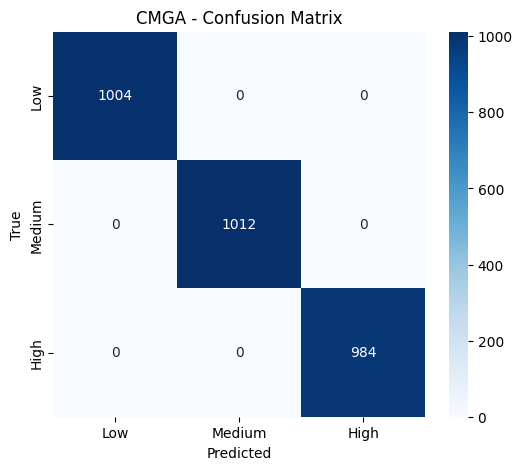

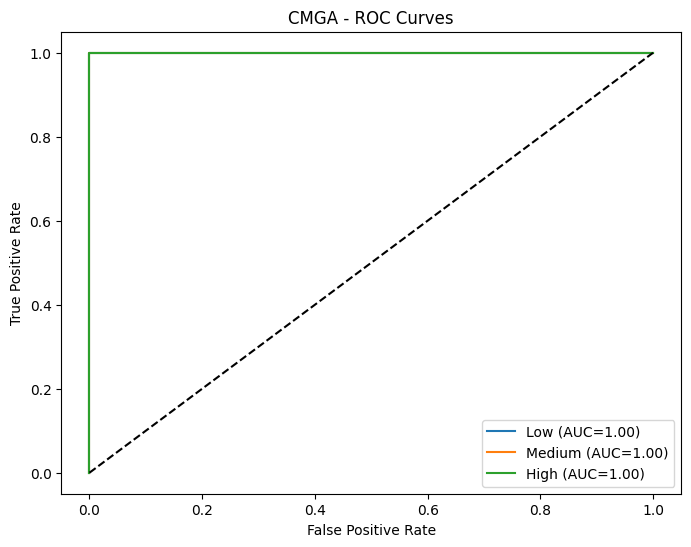

In [35]:
model = CMGA()
train_model(model, train_loader, val_loader, model_name="CMGA", epochs=5)
evaluate_model(model, test_loader, model_name="CMGA")


In [38]:
def generate_synthetic_data(n=20000):
    data = []
    for _ in range(n):
        label = random.choice(['Low', 'Medium', 'High'])

        # Base vitals: [HR, SBP, DBP, SpO2, Temp, RespRate]
        vitals = np.random.normal(loc=0.5, scale=0.12, size=6)
        vitals = np.clip(vitals, 0.0, 1.0)

        # Probabilistic shifts (not deterministic!)
        if label == 'High':
            if random.random() < 0.85:
                vitals[0] = np.clip(vitals[0] + np.random.uniform(0.15, 0.4), 0, 1)  # ↑ HR
            if random.random() < 0.8:
                vitals[3] = np.clip(vitals[3] - np.random.uniform(0.15, 0.4), 0, 1)  # ↓ SpO2
        elif label == 'Medium':
            if random.random() < 0.7:
                vitals[0] = np.clip(vitals[0] + np.random.uniform(0.08, 0.22), 0, 1)
            if random.random() < 0.65:
                vitals[3] = np.clip(vitals[3] - np.random.uniform(0.08, 0.22), 0, 1)

        # Add measurement noise
        vitals += np.random.normal(0, 0.025, size=6)
        vitals = np.clip(vitals, 0, 1)

        # Note phrasing with ambiguity
        note_templates = [
            "Patient is {}.",
            "Reports feeling {}.",
            "Observed: {}.",
            "Clinical note: {}.",
            "Appears {}.",
            "No acute issues, but {} mentioned.",
        ]
        phrase = random.choice(risk_phrases[label])

        # Occasionally use misleading/milder phrasing
        if label == 'High' and random.random() < 0.15:
            phrase = random.choice(risk_phrases['Medium'])
        elif label == 'Low' and random.random() < 0.1:
            phrase = random.choice(["mild fatigue", "slightly anxious", "occasional palpitations"])

        note = random.choice(note_templates).format(phrase)
        data.append({'vitals': vitals.tolist(), 'note': note, 'label': label2idx[label]})

    # === Apply label noise AFTER full generation ===
    num_flip = int(0.07 * len(data))  # 7% label noise
    flip_indices = np.random.choice(len(data), size=num_flip, replace=False)
    for i in flip_indices:
        true_label = data[i]['label']
        other_labels = [l for l in [0, 1, 2] if l != true_label]
        data[i]['label'] = random.choice(other_labels)

    return pd.DataFrame(data)

In [39]:
df = generate_synthetic_data(20000)
df.to_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))

✅ Dataset loaded. Shape: (20000, 3)

=== Label Distribution ===
label
0    6669
1    6546
2    6785
Name: count, dtype: int64
→ Should be roughly balanced (≈6,600 per class)

=== Sample Records (Look for ambiguity) ===
                                                    note  label
13945  No acute issues, but tachycardic and hypoxemic...      2
1604                          Reports feeling very weak.      2
18588  No acute issues, but slightly hypotensive ment...      1
18004                 Clinical note: alert and oriented.      0
11442                        Appears alert and oriented.      0
18377                            Clinical note: fatigue.      1
14405                             Observed: no distress.      0
8470                       Appears respiratory distress.      2
8780                            Observed: normal vitals.      0
6229                       Appears slightly hypotensive.      1

=== Vitals Statistics by Class ===
           HR                            

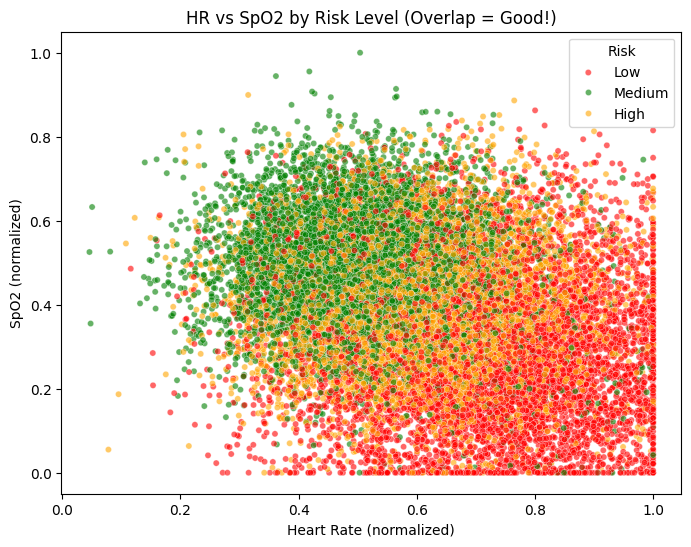


=== Potential Conflicting Examples ===
Found examples where note suggests high risk but vitals are normal:
• Observed: no distress. | HR:0.52, SpO2:0.63 | Label: Low
• Clinical note: respiratory distress. | HR:0.49, SpO2:0.65 | Label: High
• Patient is respiratory distress. | HR:0.58, SpO2:0.73 | Label: High
• Reports feeling no distress. | HR:0.59, SpO2:0.65 | Label: Low
• Reports feeling respiratory distress. | HR:0.47, SpO2:0.70 | Label: High


In [40]:
# 1. Load the dataset
df = pd.read_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))
print("✅ Dataset loaded. Shape:", df.shape)
print("\n=== Label Distribution ===")
print(df['label'].value_counts().sort_index())
print("→ Should be roughly balanced (≈6,600 per class)")

# 2. Check for label noise & ambiguity
print("\n=== Sample Records (Look for ambiguity) ===")
print(df[['note', 'label']].sample(10))

# 3. Inspect vitals distributions by class
vitals_df = pd.DataFrame(df['vitals'].tolist(), columns=['HR', 'SBP', 'DBP', 'SpO2', 'Temp', 'Resp'])
vitals_df['label'] = df['label']

print("\n=== Vitals Statistics by Class ===")
print(vitals_df.groupby('label')[['HR', 'SpO2']].describe())

# 4. Visualize overlap (HR vs SpO2)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=vitals_df,
    x='HR', y='SpO2',
    hue='label',
    palette=['green', 'orange', 'red'],
    alpha=0.6,
    s=20
)
plt.title("HR vs SpO2 by Risk Level (Overlap = Good!)")
plt.xlabel("Heart Rate (normalized)")
plt.ylabel("SpO2 (normalized)")
plt.legend(title='Risk', labels=['Low', 'Medium', 'High'])
plt.show()

# 5. Check for conflicting examples (e.g., high-risk note but normal vitals)
print("\n=== Potential Conflicting Examples ===")
# Find "High" notes but normal HR/SpO2
high_phrases = ['tachycardic', 'hypoxemic', 'unresponsive', 'distress', 'severe']
conflicting = []
for idx, row in df.iterrows():
    note = row['note'].lower()
    vitals = row['vitals']
    hr, spo2 = vitals[0], vitals[3]
    # Normal range: HR ~0.4–0.6, SpO2 ~0.6–0.8 (in normalized space)
    if any(phrase in note for phrase in high_phrases) and (0.4 < hr < 0.6) and (0.6 < spo2 < 0.8):
        conflicting.append((row['note'], f"HR:{hr:.2f}, SpO2:{spo2:.2f}", row['label']))
        if len(conflicting) >= 5:
            break

if conflicting:
    print("Found examples where note suggests high risk but vitals are normal:")
    for note, vitals, label in conflicting:
        print(f"• {note} | {vitals} | Label: {['Low','Medium','High'][label]}")
else:
    print("No obvious conflicting examples found (try lowering thresholds if needed).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Realistic synthetic dataset saved.

🚀 Training CMGA...
Epoch 1/6 | Val Acc: 0.8770
Epoch 2/6 | Val Acc: 0.8737
Epoch 3/6 | Val Acc: 0.8713
Epoch 4/6 | Val Acc: 0.8650
Epoch 5/6 | Val Acc: 0.8750
Epoch 6/6 | Val Acc: 0.8757

=== CMGA Test Results ===
              precision    recall  f1-score   support

         Low       0.92      0.94      0.93      1005
      Medium       0.84      0.92      0.88       998
        High       0.92      0.81      0.86       997

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

Macro F1: 0.890590392563781
Accuracy: 0.8913333333333333
ROC-AUC (macro): 0.936336918163871


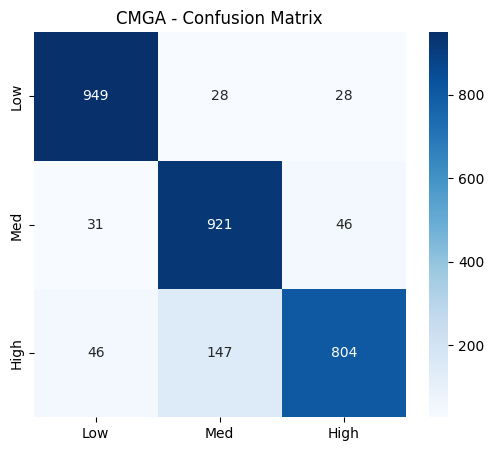

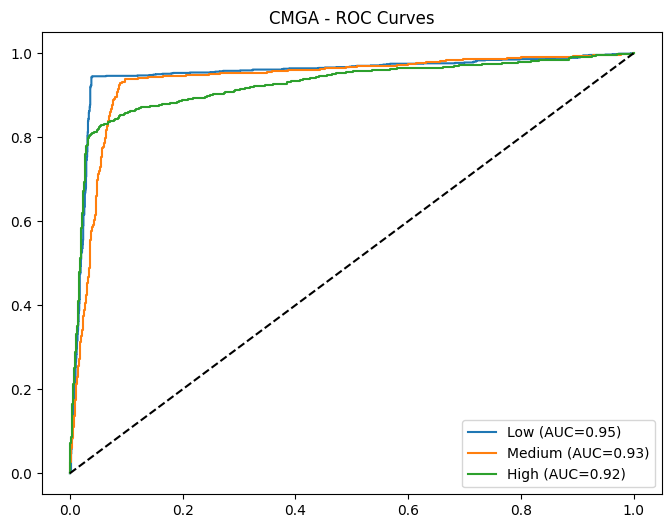


🚀 Training BaselineConcat...
Epoch 1/6 | Val Acc: 0.8680
Epoch 2/6 | Val Acc: 0.8710
Epoch 3/6 | Val Acc: 0.8710
Epoch 4/6 | Val Acc: 0.8710
Epoch 5/6 | Val Acc: 0.8703
Epoch 6/6 | Val Acc: 0.8710

=== BaselineConcat Test Results ===
              precision    recall  f1-score   support

         Low       0.92      0.94      0.93      1005
      Medium       0.82      0.94      0.88       998
        High       0.93      0.78      0.85       997

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

Macro F1: 0.8862197928438573
Accuracy: 0.8873333333333333
ROC-AUC (macro): 0.9292294360011352


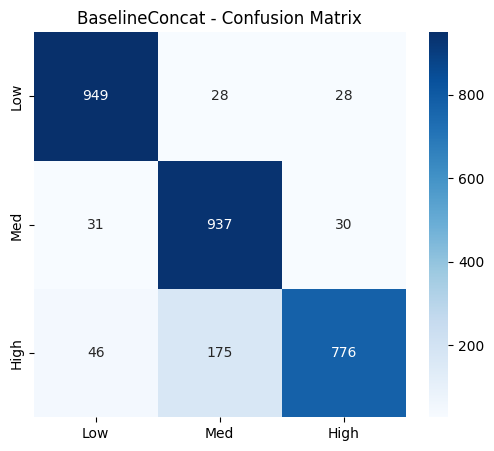

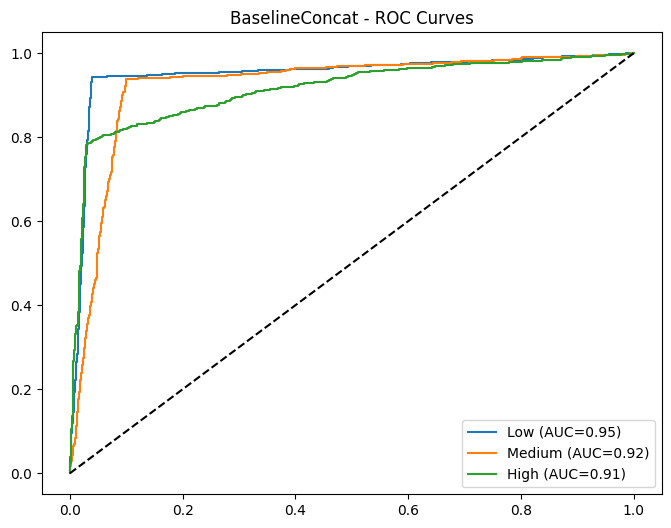


🚀 Training LateFusion...
Epoch 1/6 | Val Acc: 0.8653
Epoch 2/6 | Val Acc: 0.8680
Epoch 3/6 | Val Acc: 0.8703
Epoch 4/6 | Val Acc: 0.8707
Epoch 5/6 | Val Acc: 0.8747
Epoch 6/6 | Val Acc: 0.8713

=== LateFusion Test Results ===
              precision    recall  f1-score   support

         Low       0.92      0.94      0.93      1005
      Medium       0.82      0.94      0.88       998
        High       0.93      0.78      0.85       997

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

Macro F1: 0.886945460328902
Accuracy: 0.888
ROC-AUC (macro): 0.9346645588645383


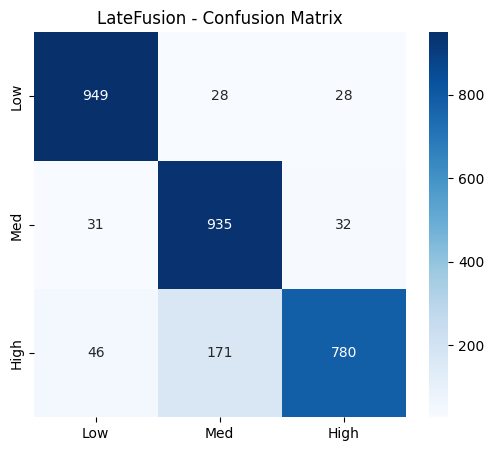

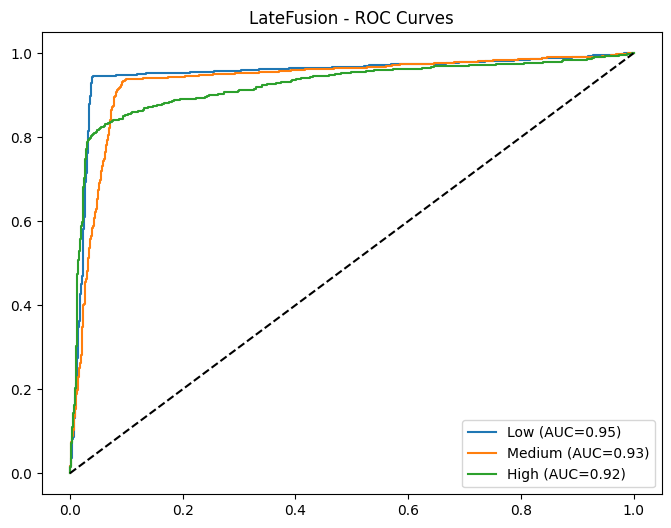


🚀 Training SimpleCrossAttention...
Epoch 1/6 | Val Acc: 0.8637
Epoch 2/6 | Val Acc: 0.8670
Epoch 3/6 | Val Acc: 0.8710
Epoch 4/6 | Val Acc: 0.8710
Epoch 5/6 | Val Acc: 0.8683
Epoch 6/6 | Val Acc: 0.8710

=== SimpleCrossAttention Test Results ===
              precision    recall  f1-score   support

         Low       0.92      0.94      0.93      1005
      Medium       0.82      0.94      0.88       998
        High       0.93      0.78      0.85       997

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

Macro F1: 0.8862197928438573
Accuracy: 0.8873333333333333
ROC-AUC (macro): 0.9285894020322135


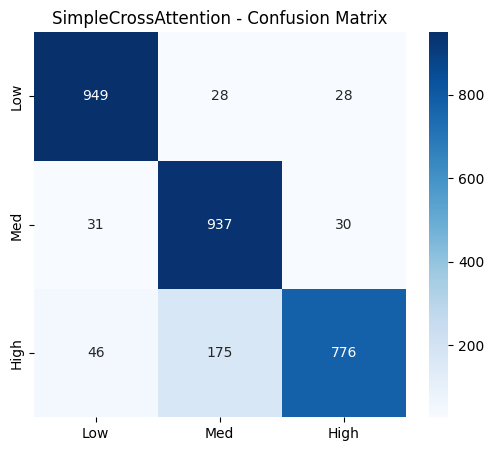

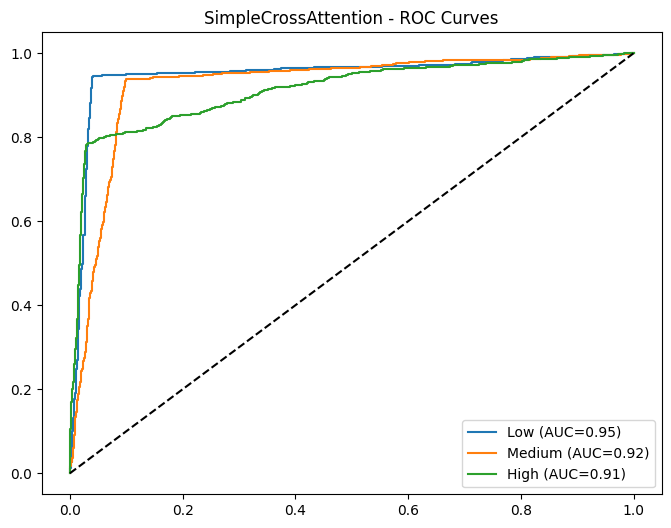

In [41]:
# ==============================
# 1. SETUP & INSTALL
# ==============================
from google.colab import drive
drive.mount('/content/drive')

!pip install nlpaug transformers scikit-learn matplotlib seaborn

import os
PROJECT_PATH = "/content/drive/MyDrive/Lukcy project"
os.makedirs(PROJECT_PATH, exist_ok=True)

# ==============================
# 2. IMPORTS & SEEDS
# ==============================
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, f1_score, accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel

# Fix NLTK for nlpaug
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

import nlpaug.augmenter.word as naw
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.2)

# Seeds
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==============================
# 3. SYNTHETIC DATA GENERATION
# ==============================
risk_phrases = {
    'Low': ["stable", "no distress", "normal vitals", "alert and oriented", "breathing comfortably"],
    'Medium': ["mild tachycardia", "slightly hypotensive", "mild dyspnea", "fatigue", "anxious but responsive"],
    'High': ["tachycardic and hypoxemic", "unresponsive", "severe hypotension", "respiratory distress", "cyanotic"]
}
label2idx = {'Low': 0, 'Medium': 1, 'High': 2}

def generate_synthetic_data(n=20000):
    data = []
    for _ in range(n):
        label = random.choice(['Low', 'Medium', 'High'])
        vitals = np.random.normal(loc=0.5, scale=0.12, size=6)
        vitals = np.clip(vitals, 0.0, 1.0)

        # Probabilistic shifts
        if label == 'High':
            if random.random() < 0.85:
                vitals[0] = np.clip(vitals[0] + np.random.uniform(0.15, 0.4), 0, 1)
            if random.random() < 0.8:
                vitals[3] = np.clip(vitals[3] - np.random.uniform(0.15, 0.4), 0, 1)
        elif label == 'Medium':
            if random.random() < 0.7:
                vitals[0] = np.clip(vitals[0] + np.random.uniform(0.08, 0.22), 0, 1)
            if random.random() < 0.65:
                vitals[3] = np.clip(vitals[3] - np.random.uniform(0.08, 0.22), 0, 1)

        vitals += np.random.normal(0, 0.025, size=6)
        vitals = np.clip(vitals, 0, 1)

        note_templates = [
            "Patient is {}.",
            "Reports feeling {}.",
            "Observed: {}.",
            "Clinical note: {}.",
            "Appears {}.",
            "No acute issues, but {} mentioned."
        ]
        phrase = random.choice(risk_phrases[label])
        if label == 'High' and random.random() < 0.15:
            phrase = random.choice(risk_phrases['Medium'])
        elif label == 'Low' and random.random() < 0.1:
            phrase = random.choice(["mild fatigue", "slightly anxious"])

        note = random.choice(note_templates).format(phrase)
        data.append({'vitals': vitals.tolist(), 'note': note, 'label': label2idx[label]})

    # Add 7% label noise
    num_flip = int(0.07 * len(data))
    flip_indices = np.random.choice(len(data), size=num_flip, replace=False)
    for i in flip_indices:
        true_label = data[i]['label']
        other_labels = [l for l in [0,1,2] if l != true_label]
        data[i]['label'] = random.choice(other_labels)

    return pd.DataFrame(data)

# Save dataset
df = generate_synthetic_data(20000)
df.to_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))
print("✅ Realistic synthetic dataset saved.")

# ==============================
# 4. DATASET & DATALOADER
# ==============================
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EHRTorchDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vitals = torch.tensor(row['vitals'], dtype=torch.float32)
        note = row['note']
        label = torch.tensor(row['label'], dtype=torch.long)

        if self.augment and random.random() < 0.5:
            try:
                aug_note = aug.augment(note)
                note = aug_note[0] if isinstance(aug_note, list) else aug_note
                vitals = vitals + torch.randn_like(vitals) * 0.02
                vitals = torch.clamp(vitals, 0, 1)
            except:
                pass

        encoding = tokenizer(note, truncation=True, padding='max_length', max_length=64, return_tensors='pt')
        return vitals, encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), label

# Load & split
df = pd.read_pickle(os.path.join(PROJECT_PATH, "synthetic_ehr.pkl"))
train_df, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

train_loader = DataLoader(EHRTorchDataset(train_df, augment=True), batch_size=32, shuffle=True)
val_loader = DataLoader(EHRTorchDataset(val_df), batch_size=64)
test_loader = DataLoader(EHRTorchDataset(test_df), batch_size=64)

# ==============================
# 5. MODELS
# ==============================
class BERTTextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state.mean(dim=1)

class BaselineConcat(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.classifier = nn.Sequential(
            nn.Linear(6 + 768, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, 3)
        )
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        x = torch.cat([vitals, text_emb], dim=1)
        return self.classifier(x)

class LateFusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.vital_net = nn.Sequential(nn.Linear(6, 128), nn.ReLU(), nn.Linear(128, 3))
        self.text_net = nn.Sequential(nn.Linear(768, 128), nn.ReLU(), nn.Linear(128, 3))
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        return (self.vital_net(vitals) + self.text_net(text_emb)) / 2

class SimpleCrossAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.v_proj = nn.Linear(6, 128)
        self.t_proj = nn.Linear(768, 128)
        self.attn = nn.MultiheadAttention(128, num_heads=4, batch_first=True)
        self.classifier = nn.Linear(128 + 6, 3)
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        v = self.v_proj(vitals)
        t = self.t_proj(text_emb)
        attn_out, _ = self.attn(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        fused = torch.cat([attn_out.squeeze(1), vitals], dim=1)
        return self.classifier(fused)

class CMGA(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_encoder = BERTTextEncoder()
        self.v_proj = nn.Linear(6, 128)
        self.t_proj = nn.Linear(768, 128)
        self.attn_v2t = nn.MultiheadAttention(128, num_heads=4, batch_first=True)
        self.attn_t2v = nn.MultiheadAttention(128, num_heads=4, batch_first=True)
        self.gate_v = nn.Linear(256, 128)
        self.gate_t = nn.Linear(256, 128)
        self.classifier = nn.Linear(256, 3)
    def forward(self, vitals, input_ids, attention_mask):
        text_emb = self.text_encoder(input_ids, attention_mask)
        v = self.v_proj(vitals)
        t = self.t_proj(text_emb)
        v2t, _ = self.attn_v2t(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        t2v, _ = self.attn_t2v(t.unsqueeze(1), v.unsqueeze(1), v.unsqueeze(1))
        v2t, t2v = v2t.squeeze(1), t2v.squeeze(1)
        gate_v = torch.sigmoid(self.gate_v(torch.cat([v, v2t], dim=1)))
        gate_t = torch.sigmoid(self.gate_t(torch.cat([t, t2v], dim=1)))
        fused_v = gate_v * v + (1 - gate_v) * v2t
        fused_t = gate_t * t + (1 - gate_t) * t2v
        out = torch.cat([fused_v, fused_t], dim=1)
        return self.classifier(out)

# ==============================
# 6. TRAINING & EVALUATION
# ==============================
def train_model(model, train_loader, val_loader, epochs=8, lr=1e-3, model_name="CMGA"):
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        for vitals, ids, mask, labels in train_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(vitals, ids, mask), labels)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for vitals, ids, mask, labels in val_loader:
                vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
                preds = model(vitals, ids, mask).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = correct / total
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), os.path.join(PROJECT_PATH, f"{model_name}_best.pth"))
        print(f"Epoch {epoch+1}/{epochs} | Val Acc: {acc:.4f}")

def evaluate_model(model, test_loader, model_name="CMGA"):
    model.load_state_dict(torch.load(os.path.join(PROJECT_PATH, f"{model_name}_best.pth"), map_location=device))
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for vitals, ids, mask, labels in test_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            outputs = model(vitals, ids, mask)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    all_labels, all_preds, all_probs = map(np.array, (all_labels, all_preds, all_probs))
    # Metrics
    print(f"\n=== {model_name} Test Results ===")
    print(classification_report(all_labels, all_preds, target_names=['Low','Medium','High']))
    print("Macro F1:", f1_score(all_labels, all_preds, average='macro'))
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("ROC-AUC (macro):", roc_auc_score(all_labels, all_probs, multi_class='ovr'))
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Med','High'], yticklabels=['Low','Med','High'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.savefig(os.path.join(PROJECT_PATH, f"{model_name}_cm.png"), bbox_inches='tight')
    plt.show()
    # ROC
    plt.figure(figsize=(8,6))
    for i, name in enumerate(['Low','Medium','High']):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:,i])
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(all_labels==i, all_probs[:,i]):.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.legend(); plt.title(f'{model_name} - ROC Curves')
    plt.savefig(os.path.join(PROJECT_PATH, f"{model_name}_roc.png"), bbox_inches='tight')
    plt.show()

# ==============================
# 7. RUN EXPERIMENTS
# ==============================
models = {
    "CMGA": CMGA(),
    "BaselineConcat": BaselineConcat(),
    "LateFusion": LateFusion(),
    "SimpleCrossAttention": SimpleCrossAttention()
}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    train_model(model, train_loader, val_loader, epochs=6, model_name=name)
    evaluate_model(model, test_loader, model_name=name)

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch
import torch.nn.functional as F

def get_metrics(model, test_loader, model_name):
    model.load_state_dict(torch.load(os.path.join(PROJECT_PATH, f"{model_name}_best.pth"), map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for vitals, ids, mask, labels in test_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            outputs = model(vitals, ids, mask)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    return prec, rec, f1, auc

# Evaluate all models
model_names = ["CMGA", "BaselineConcat", "LateFusion", "SimpleCrossAttention"]
results = {}

for name in model_names:
    try:
        prec, rec, f1, auc = get_metrics(globals()[name](), test_loader, name)
        results[name] = {"Precision": prec, "Recall": rec, "F1": f1, "ROC-AUC": auc}
    except Exception as e:
        print(f"⚠️ Skipping {name}: {str(e)}")

# Print clean table
print(f"{'Model':<20} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC-AUC':<10}")
print("-" * 65)
for name, met in results.items():
    print(f"{name:<20} {met['Precision']:<10.4f} {met['Recall']:<10.4f} {met['F1']:<10.4f} {met['ROC-AUC']:<10.4f}")

Model                Precision  Recall     F1         ROC-AUC   
-----------------------------------------------------------------
CMGA                 0.8937     0.8912     0.8906     0.9363    
BaselineConcat       0.8924     0.8872     0.8862     0.9292    
LateFusion           0.8927     0.8878     0.8869     0.9347    
SimpleCrossAttention 0.8924     0.8872     0.8862     0.9286    


In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import torch
import torch.nn.functional as F

def get_metrics(model, test_loader, model_name):
    model.load_state_dict(torch.load(os.path.join(PROJECT_PATH, f"{model_name}_best.pth"), map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for vitals, ids, mask, labels in test_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            outputs = model(vitals, ids, mask)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    return acc, prec, rec, f1, auc

# Evaluate all models
model_names = ["CMGA", "BaselineConcat", "LateFusion", "SimpleCrossAttention"]
results = {}

for name in model_names:
    try:
        acc, prec, rec, f1, auc = get_metrics(globals()[name](), test_loader, name)
        results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC-AUC": auc}
    except Exception as e:
        print(f"⚠️ Skipping {name}: {str(e)}")

# Print clean table
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC-AUC':<10}")
print("-" * 85)
for name, met in results.items():
    print(f"{name:<20} {met['Accuracy']:<10.4f} {met['Precision']:<10.4f} {met['Recall']:<10.4f} {met['F1']:<10.4f} {met['ROC-AUC']:<10.4f}")

Model                Accuracy   Precision  Recall     F1         ROC-AUC   
-------------------------------------------------------------------------------------
CMGA                 0.8913     0.8937     0.8912     0.8906     0.9363    
BaselineConcat       0.8873     0.8924     0.8872     0.8862     0.9292    
LateFusion           0.8880     0.8927     0.8878     0.8869     0.9347    
SimpleCrossAttention 0.8873     0.8924     0.8872     0.8862     0.9286    


✅ Loaded predictions for CMGA
✅ Loaded predictions for BaselineConcat
✅ Loaded predictions for LateFusion
✅ Loaded predictions for SimpleCrossAttention

✅ Metrics saved to final_results.csv


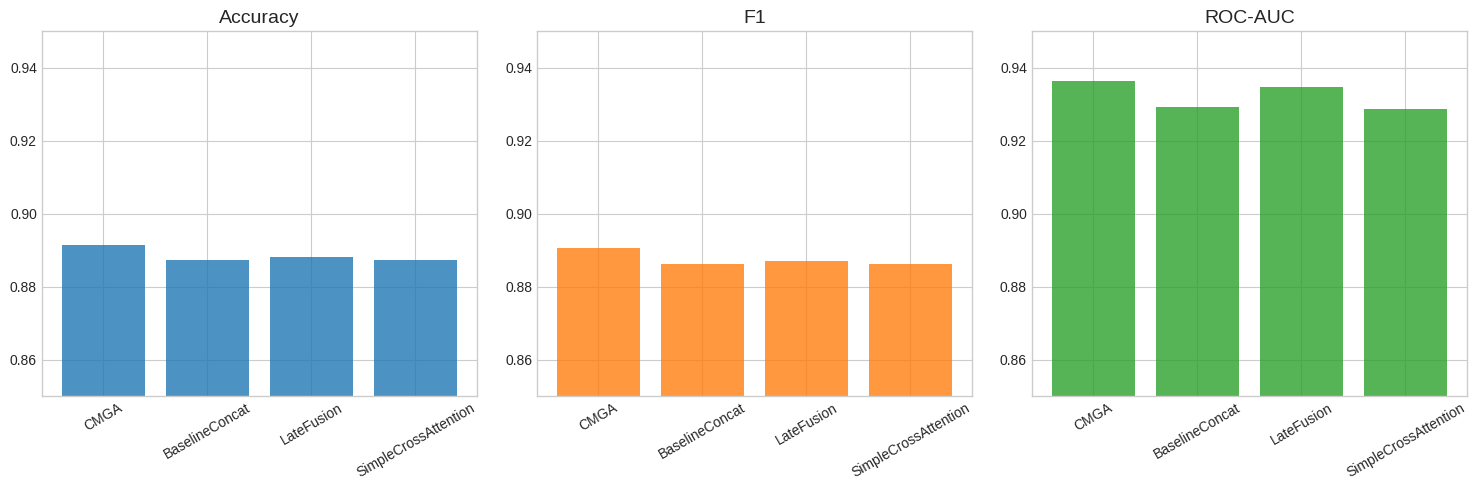

✅ Bar chart saved: /content/drive/MyDrive/Lukcy project/model_comparison_bars.png


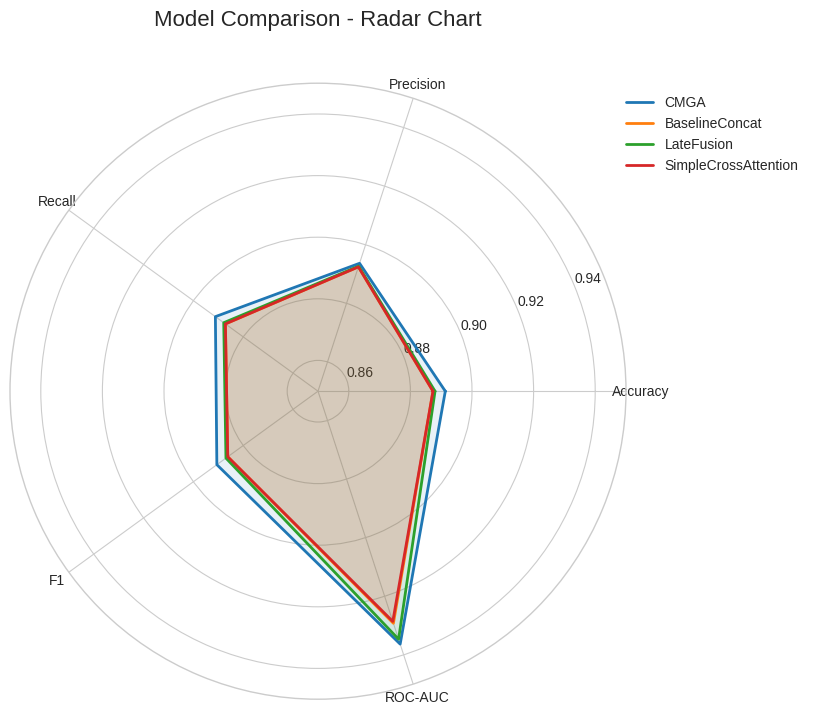

✅ Radar chart saved: /content/drive/MyDrive/Lukcy project/model_comparison_radar.png


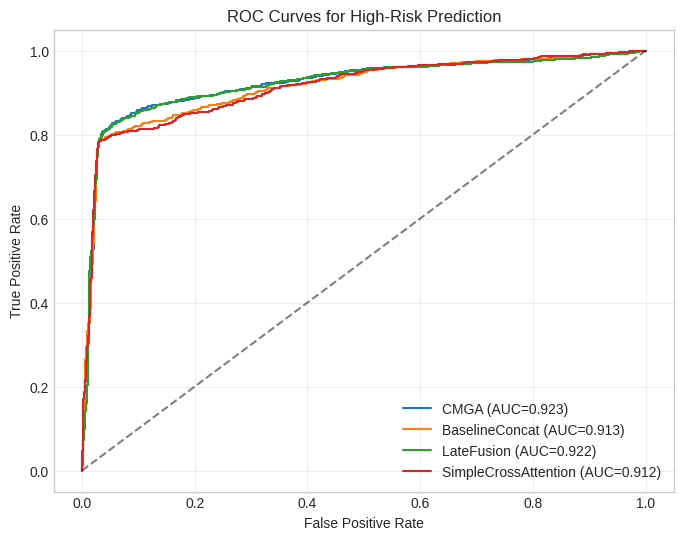

✅ High-risk ROC saved: /content/drive/MyDrive/Lukcy project/high_risk_roc_comparison.png

🎉 All visualizations saved to 'Lukcy project' folder!


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
import torch
import torch.nn.functional as F
import os

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("tab10")

# Reuse device and test_loader from your environment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 1. Collect metrics and probabilities for all models ---
def get_full_predictions(model, test_loader, model_name):
    model.load_state_dict(torch.load(os.path.join(PROJECT_PATH, f"{model_name}_best.pth"), map_location=device))
    model.to(device)
    model.eval()

    all_probs, all_labels = [], []
    with torch.no_grad():
        for vitals, ids, mask, labels in test_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            outputs = model(vitals, ids, mask)
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_probs), np.array(all_labels)

# Evaluate all models
model_names = ["CMGA", "BaselineConcat", "LateFusion", "SimpleCrossAttention"]
results = []
roc_data = {}

for name in model_names:
    try:
        model_instance = globals()[name]()
        probs, labels = get_full_predictions(model_instance, test_loader, name)
        roc_data[name] = (probs, labels)

        # Compute metrics
        preds = probs.argmax(axis=1)
        acc = accuracy_score(labels, preds)
        prec = precision_score(labels, preds, average='macro')
        rec = recall_score(labels, preds, average='macro')
        f1 = f1_score(labels, preds, average='macro')
        auc = roc_auc_score(labels, probs, multi_class='ovr')

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "ROC-AUC": auc
        })
        print(f"✅ Loaded predictions for {name}")
    except Exception as e:
        print(f"⚠️ Skipping {name}: {e}")

df_results = pd.DataFrame(results)
df_results = df_results.set_index("Model")

# --- 2. Save metrics table ---
df_results.to_csv(os.path.join(PROJECT_PATH, "final_results.csv"))
print("\n✅ Metrics saved to final_results.csv")

# --- 3. Plot 1: Bar Chart (Accuracy, F1, ROC-AUC) ---
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ["Accuracy", "F1", "ROC-AUC"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax[i].bar(df_results.index, df_results[metric], color=color, alpha=0.8)
    ax[i].set_title(f'{metric}', fontsize=14)
    ax[i].set_ylim(0.85, 0.95)
    ax[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
bar_path = os.path.join(PROJECT_PATH, "model_comparison_bars.png")
plt.savefig(bar_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Bar chart saved: {bar_path}")

# --- 4. Plot 2: Radar Chart (All Metrics) ---
from math import pi

# Normalize metrics for radar (optional: already comparable)
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
num_vars = len(metrics)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for model in df_results.index:
    values = df_results.loc[model, metrics].tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0.85, 0.95)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title("Model Comparison - Radar Chart", size=16, y=1.08)

radar_path = os.path.join(PROJECT_PATH, "model_comparison_radar.png")
plt.savefig(radar_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Radar chart saved: {radar_path}")

# --- 5. Plot 3: ROC Curves (High-risk class only) ---
plt.figure(figsize=(8, 6))

for name in model_names:
    if name in roc_data:
        probs, labels = roc_data[name]
        # High-risk = class 2
        fpr, tpr, _ = roc_curve(labels == 2, probs[:, 2])
        auc = roc_auc_score(labels == 2, probs[:, 2])
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for High-Risk Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

roc_path = os.path.join(PROJECT_PATH, "high_risk_roc_comparison.png")
plt.savefig(roc_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ High-risk ROC saved: {roc_path}")

print("\n🎉 All visualizations saved to 'Lukcy project' folder!")

✅ CMGA evaluated
✅ BaselineConcat evaluated
✅ LateFusion evaluated
✅ SimpleCrossAttention evaluated


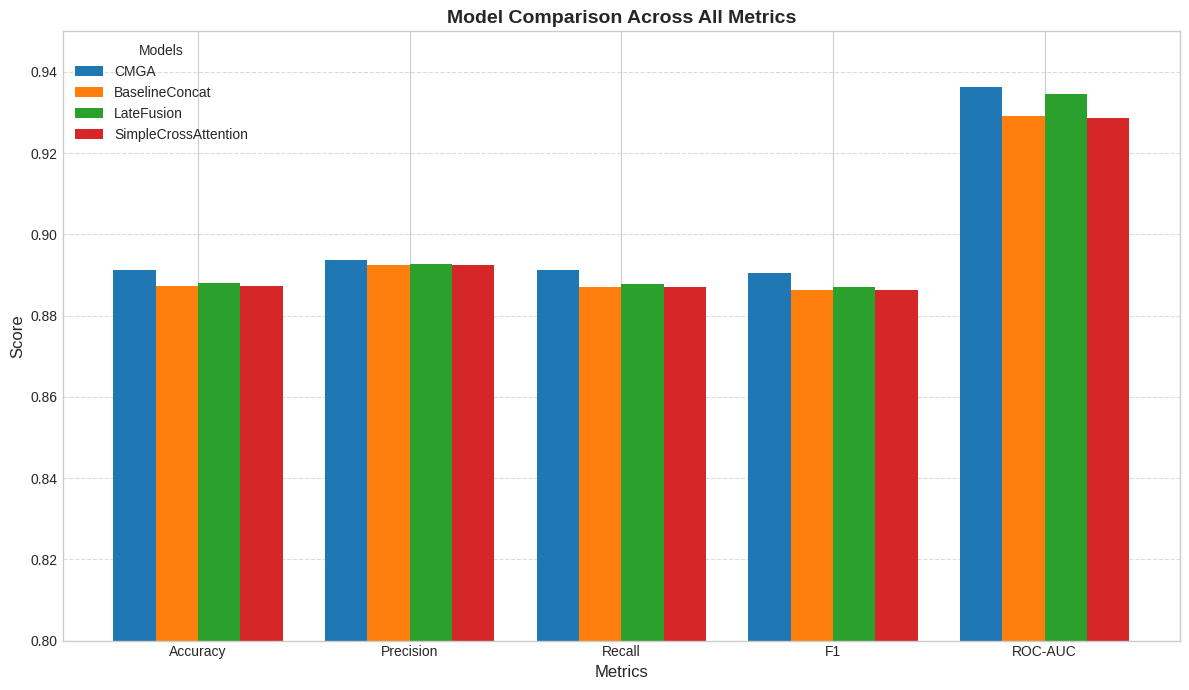


✅ Unified comparison plot saved to: /content/drive/MyDrive/Lukcy project/unified_model_comparison.png


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn.functional as F

# Ensure GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to extract metrics
def get_metrics(model, test_loader, model_name):
    model.load_state_dict(torch.load(os.path.join(PROJECT_PATH, f"{model_name}_best.pth"), map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for vitals, ids, mask, labels in test_loader:
            vitals, ids, mask, labels = vitals.to(device), ids.to(device), mask.to(device), labels.to(device)
            outputs = model(vitals, ids, mask)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    return {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds, average='macro'),
        "Recall": recall_score(all_labels, all_preds, average='macro'),
        "F1": f1_score(all_labels, all_preds, average='macro'),
        "ROC-AUC": roc_auc_score(all_labels, all_probs, multi_class='ovr')
    }

# Evaluate all models
model_names = ["CMGA", "BaselineConcat", "LateFusion", "SimpleCrossAttention"]
all_metrics = {}

for name in model_names:
    try:
        model_instance = globals()[name]()
        all_metrics[name] = get_metrics(model_instance, test_loader, name)
        print(f"✅ {name} evaluated")
    except Exception as e:
        print(f"⚠️ {name} failed: {e}")

# Convert to DataFrame
df = pd.DataFrame(all_metrics).T  # Models as rows, metrics as columns

# --- Plot: Unified grouped bar chart ---
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
x = np.arange(len(metrics))
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(12, 7))

# Plot each model
for i, model in enumerate(model_names):
    if model in df.index:
        ax.bar(x + i * width, df.loc[model, metrics], width, label=model)

# Labels and title
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Comparison Across All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics)
ax.set_ylim(0.80, 0.95)
ax.legend(title="Models")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save and show
plot_path = os.path.join(PROJECT_PATH, "unified_model_comparison.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Unified comparison plot saved to: {plot_path}")